# Implementing some findings and results from this paper:
https://www.frontiersin.org/journals/physiology/articles/10.3389/fphys.2022.1017350/full

In [9]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

### Load Base Data

In [2]:
CHI_FOLDER = "./heart-rate-oscillations-during-meditation-1.0.0/data/chi/"

In [3]:
chiPre, chiMed = (pd.read_csv(CHI_FOLDER+"C1.pre", sep=' ', header=None, names=['Timestamp', 'HeartRate']),pd.read_csv(CHI_FOLDER+"C1.med", sep=' ', header=None, names=['Timestamp', 'HeartRate']))

### SDNN and RMSSD

In [4]:
def sdnn(df):
    df = df.copy()
    df['IBI'] = df['Timestamp'].diff() * 1000
    
    # Drop the first row since diff() creates a NaN
    df = df.dropna().reset_index(drop=True)
    
    # SDNN: Standard Deviation of Normal-to-Normal IBIs
    sdnn = np.std(df['IBI'])
    
    del df
    return sdnn

def rmssd(df):
    df = df.copy()
    df['IBI'] = df['Timestamp'].diff() * 1000
    
    # Drop the first row since diff() creates a NaN
    df = df.dropna().reset_index(drop=True)
    
    # RMSSD: Root Mean Square of Successive Differences
    # Calculate the differences between successive IBIs
    diff_ibi = np.diff(df['IBI'])
    rmssd = np.sqrt(np.mean(diff_ibi**2))
    
    del df
    return rmssd

In [5]:
sdnn(chiPre)

np.float64(233.0209868458547)

In [6]:
rmssd(chiPre)

np.float64(302.7660408842301)

### ABI

In [10]:
def calculate_abi(df):

    df = df.copy()
    df['IBI'] = df['Timestamp'].diff() * 1000  # Convert to milliseconds
    df = df.dropna().reset_index(drop=True)
    
    def calculate_sdrsa(df):
        # A required step in computing the SDRSA is the measurement of the respiratory rate.
        def calculate_respitory_rate(f1=0.1, f2=0.4): #online says these are good frequency bounds for resp rate
            # 1 Define frequencies that are considered the lower and upper bound of the respiratory rate within each 2 min segment
            # Average resp rate = 12-20 bpm
            f1 = 0.1 # 6 breaths per minute
            f2 = 0.4 # 24 breaths per minute
            
            # 2 Compute the power spectral density (PSD) normalized so that ∫df P(f) = SDRR2 . 
            # The PSD is interpolated using a cubic spline. Let f0 be the frequency that corresponds to the peak of the PSD, 
            # and let A0 be the peak value. 

            #so first caculate the psd (welch's method)
            fs = 4
            f, psd = scipy.signal.welch(df['IBI'], fs, nperseg=256) 
            # interpolate using cubic spline
            cubic_spline = scipy.interpolate.CubicSpline(f, psd)
            psd_cs = cubic_spline(f) #can increase resolution later potentially
            f_inter = np.linspace(f[0], f[-1], 1000)
            psd_cs_higher_res = cubic_spline(f_inter)

            plt.figure(figsize=(10, 6))
            plt.plot(f, psd, label='Original PSD (Welch)', color='blue')
            plt.plot(f, psd_cs, label='Cubic Spline Interpolation', color='red', linestyle='--')
            plt.plot(f_inter, psd_cs_higher_res, label='Cubic Spline Interpolation', color='orange', linestyle='--')
            # plt.plot(freqs_interp, psd_norm, label='Normalized PSD', color='green', linestyle='-.')
            # plt.axvline(x=f0, color='purple', linestyle='--', label=f'Peak Frequency = {f0:.3f} Hz')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power Spectral Density')
            plt.title('Normalized PSD with Cubic Spline Interpolation')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            # 3 Fit a Gaussian G(f) = A0 exp − 1 2 ( f−f 0 σ ) 2 to the peak of the PSD described by a mean value (f0 ), 
            # a standard deviation (σ), and amplitude A0 .
            peak_psd_idx = np.argmax(psd_cs_higher_res)
            f0 = f_inter[peak_psd_idx]
            A0 = np.max(psd_cs_higher_res)

            def gaussian(f, A0, f0, std):
                return A0 * np.exp((-1/2) * ((f-f0)/(std))**2)

            popt, pcov = scipy.optimize.curve_fit(gaussian, f_inter, psd_cs_higher_res, p0=[A0, f0, 0.05], maxfev=4000)
            A0, f0, sigma = popt
            
            # Generate the Fitted Gaussian Curve
            gaussian_fit = gaussian(f_inter, A0, f0, sigma)
            
        
            # 4 Construct the residual R(f) = PSD(f) −G(f). From the residual, identify the largest peak amplitude A1 in the range f1 < f < f2 . 
            # Compute the ratio P = A0 /A1 which represents the prominence of the main peak A0 . 
            # If P is greater than a preset limit Pmin, it validates our assumption that the PSD is dominated by a single respiratory frequency. 
            # If P < Pmin, no values are returned and the data are discarded. 
            
            
            # 5 If P > Pmin, we compute the following two quantities: 1) The variance due to respiration = SDRSA2 , 
            # estimated by the area under the Gaussian curve = √2π A0 σ. 2) The normalized quantity ABI = [SDRSA/SDRR]. 
            # The algorithm returns the estimated respiratory rate f0 and ABI.

        calculate_respitory_rate()
        print("HI")
        sdrsa = 1 #placeholder 
        return sdrsa
        
    def calculate_sdrr(df):
        # Calculate Interbeat Intervals (IBIs)
        df = df.dropna().reset_index(drop=True)
        
        # Calculate SDRR
        sdrr = np.std(df['IBI'])
        return sdrr
        
    sdrsa = calculate_sdrsa(df)
    sdrr = calculate_sdrr(df)

    abi = sdrsa/sdrr
    return (abi, sdrsa, sdrr)

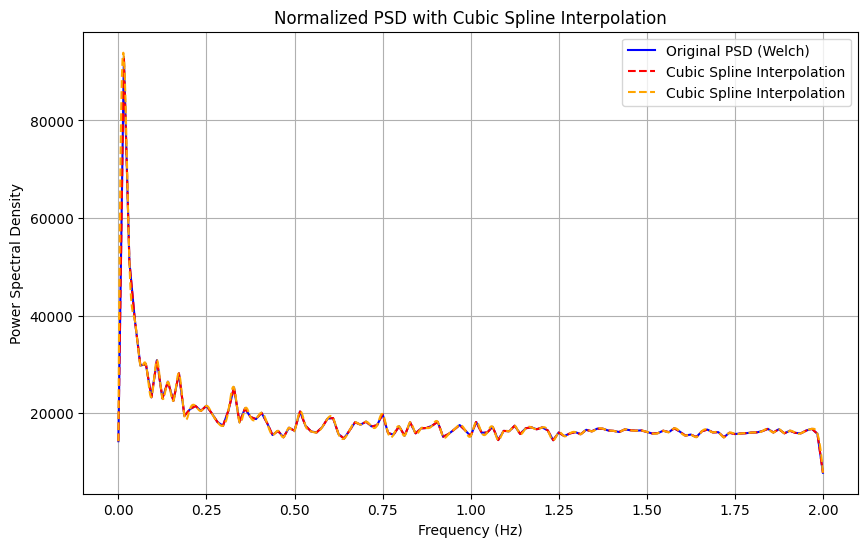

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 4000.

In [11]:
calculate_abi(chiPre)